## Load Data

In [ ]:
import pandas as pd
from scipy import signal
import numpy as np
import mne
import matplotlib.pyplot as plt
import os

path = 'D:/One_한양대학교/private object minsu/coding/data/brain_2025/day1)emotion+mist'
sub_list = os.listdir(path)
edf = mne.io.read_raw_bdf(f'{path}/{sub_list[7]}/emo.bdf', preload=True)
data = []
fs_origin = 2048
fs = 128
event = mne.find_events(edf)
edf

Extracting EDF parameters from D:\One_한양대학교\private object minsu\coding\data\day1)emotion+mist\1026_SJH\emo.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4438015  =      0.000 ...  2167.000 secs...
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
11 events found
Event IDs: [    1     2     3     4     9 65536]


<RawEDF | emo.bdf, 8 x 4438016 (2167.0 s), ~270.9 MB, data loaded>

In [35]:
data = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [3, 3, 5]])
data[[1, 3]] = data[[3, 1]]
data

array([[1, 2, 3],
       [3, 3, 5],
       [7, 8, 9],
       [4, 5, 6]])

## ICA (mne)

In [5]:
# edf = mne.io.read_raw_bdf(f'{path}/{sub_list[0]}/emo.bdf', preload=True)
edf._data *= 1e6

edf.resample(128)
event[:,0] = event[:,0] // (fs_origin // fs)
edf.notch_filter(60)
edf.filter(1,50, method='iir', iir_params=dict(order=2, ftype='butter'))

ica = mne.preprocessing.ICA(n_components=7, random_state=2222)
ica.fit(edf)
ica.exclude = [0]
ica.apply(edf)

signal_filtered = edf['data'][0]

Trigger channel has a non-zero initial value of 65536000000 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
9 events found
Event IDs: [1000000 2000000 3000000 4000000 9000000]
Trigger channel has a non-zero initial value of 65536000000 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
9 events found
Event IDs: [1000000 2000000 3000000 4000000 9000000]
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 sec)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s finished


Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 1 ICA component
    Projecting back using 7 PCA components


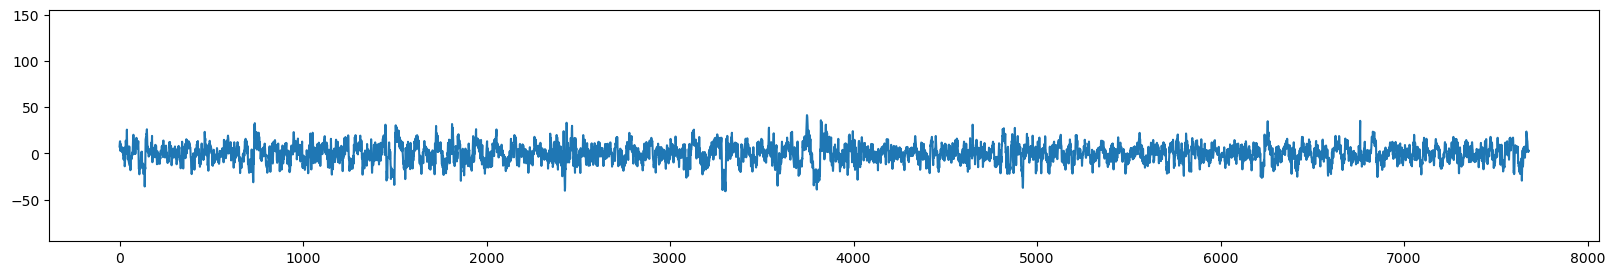

In [10]:
plt.figure(figsize=(20,3))
plt.plot(signal_filtered[0,event[1,0]:event[1,0]+fs*60])
plt.ylim(-95,155)
plt.show()

Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 1 ICA component
    Projecting back using 7 PCA components


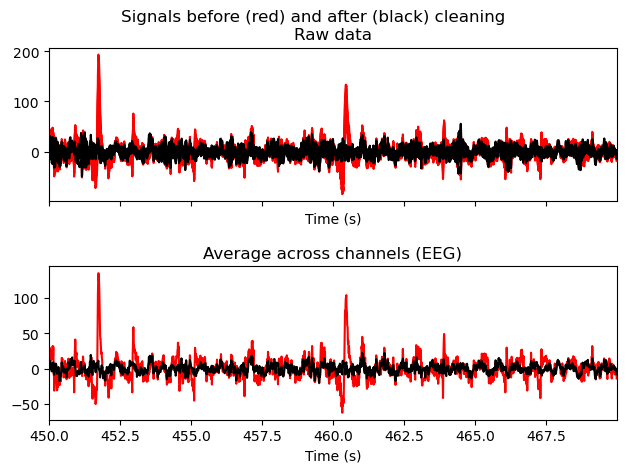

Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 2 ICA components
    Projecting back using 7 PCA components


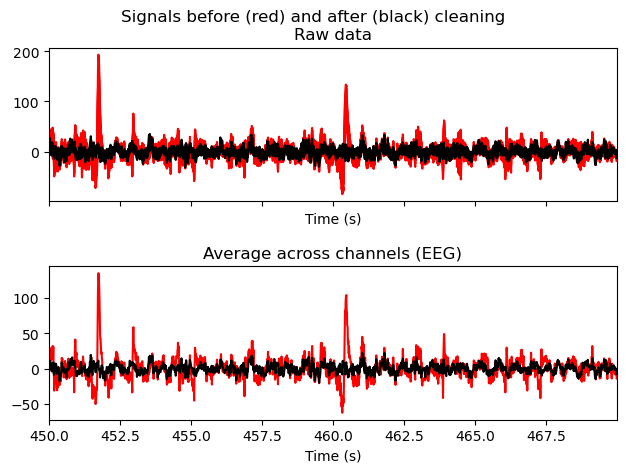

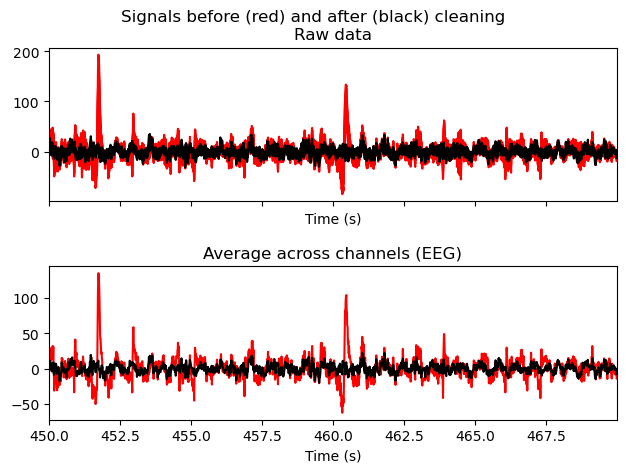

In [9]:
# ica.plot_sources(edf, picks=[0, 1])
ica.plot_overlay(edf, exclude=[0], start=128*450, stop=128*470)
ica.plot_overlay(edf, exclude=[0, 1], start=128*450, stop=128*470)

## W/O ICA (scipy)

In [2]:
# down-sampling
signal_raw = edf['data'][0] * 1e6
print(f'raw data shape: {signal_raw.shape}')
# signal_raw = signal_raw[:,:signal_raw.shape[1] // fs_origin * fs_origin]
signal_downsampled = mne.filter.resample(signal_raw, down = fs_origin // fs)
event[:,0] = event[:,0] // (fs_origin // fs)
print(f'downsampled data shape: {signal_downsampled.shape}')

raw data shape: (7, 3606528)
downsampled data shape: (7, 225408)


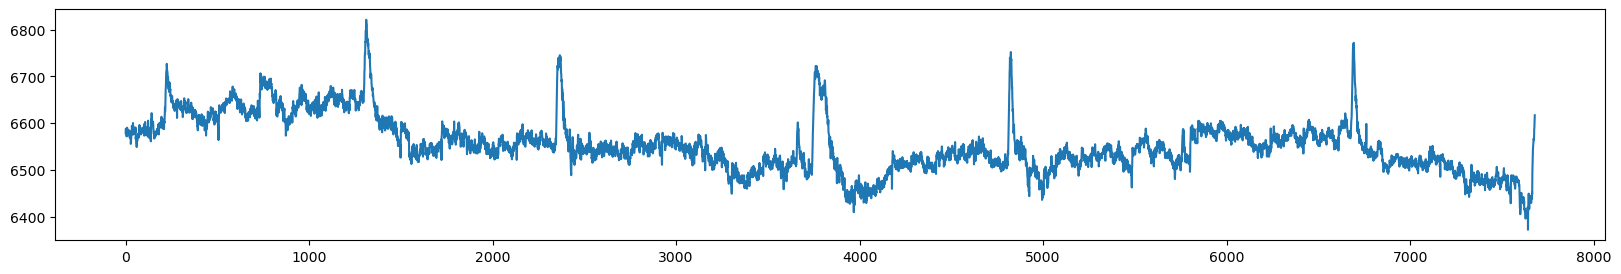

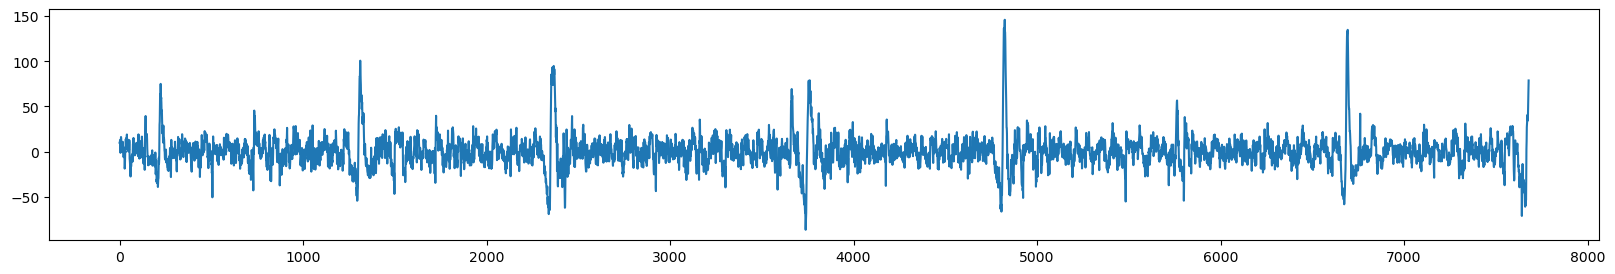

In [ ]:
# notch filter
notch_b, notch_a = signal.iirnotch(60, 30, fs)
signal_filtered = signal.filtfilt(notch_b, notch_a, signal_downsampled)

plt.figure(figsize=(20,3))
plt.plot(signal_filtered[0,event[1,0]:event[1,0]+fs*60])
plt.show()

# band-pass filtering
butter_b, butter_a = signal.butter(2, [1, 50], 'bandpass', fs=fs)
signal_filtered = signal.filtfilt(butter_b, butter_a, signal_filtered)

plt.figure(figsize=(20,3))
plt.plot(signal_filtered[0,event[1,0]:event[1,0]+fs*60])
plt.show()

## Epoching

In [3]:
# epoching
eeg_resting = []
eeg_washoff = []
eeg_ = []
for i in range(9):
    e = event[i,0]
    if event[i,2] == 9:
        eeg_resting.append(signal_filtered[:,e:e+fs*60])
        eeg_resting.append(signal_filtered[:,e+65*fs:e+fs*125])
    else:
        eeg_.append(signal_filtered[:,e:e+fs*120])

        mid_point = (e + fs*120 + signal_filtered.shape[1])//2 if i == 8 else (e + fs*120 + event[i+1,0])//2 
        eeg_washoff.append(signal_filtered[:,mid_point-fs*15:mid_point+fs*15])
        # if i != 8:
        #     eeg_washoff.append(signal_filtered[:,e+fs*120:event[i+1,0]])
        # else:
        #     eeg_washoff.append(signal_filtered[:,e+fs*120:])

eeg_resting = np.stack(eeg_resting, 0)
eeg_ = np.stack(eeg_, 0)
eeg_washoff = np.stack(eeg_washoff, 0)

In [22]:
dat_list = os.listdir(f'{path}/{sub_list[0]}')
label_raw = pd.read_csv(f'{path}/{sub_list[0]}/' + [s for s in dat_list if 'Emotion' in s][0])
label_np = np.array(label_raw[['resting','H1','H2','P1','P2','A1','A2','S1','S2']])
label_np[2,0] = -1
label_np
label_2 = np.stack([label_np[2], [0, 1, 1, 2, 2, 3, 3, 4, 4]])
label_2 = label_2[1, np.argsort(label_2[0])]
label_2

array([0., 1., 1., 2., 2., 4., 4., 3., 3.])

## fNIRS

In [1]:
from scipy.io import loadmat
import numpy as np
import mne
import matplotlib.pyplot as plt
import os

path = 'D:/One_한양대학교/private object minsu/coding/data/brain_2025'
datf = loadmat(f'{path}/fNIRS_epoch.mat')

In [15]:
datf['epoch'][0].dtype

dtype([('eors', 'O'), ('ecrs', 'O'), ('happy1', 'O'), ('happy2', 'O'), ('angry1', 'O'), ('angry2', 'O'), ('peace1', 'O'), ('peace2', 'O'), ('sad1', 'O'), ('sad2', 'O')])

In [39]:
fnirs_resting = []
fnirs_ = []
for i in range(9):
    if i < 2:
        fnirs_resting.append(datf['epoch'][0][0][i][0][0].T)
    else:
        fnirs_.append(datf['epoch'][0][0][i][0][0].T)
fnirs_resting = np.stack(fnirs_resting,0)
fnirs_ = np.stack(fnirs_,0)